In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score, plot_confusion_matrix
import seaborn as sn


In [ ]:
# from google.colab import drive (uncomment this if run from colab)
# drive.mount('/content/drive')

In [2]:
# Change the path to the folder of the dataset and the h5 file
path = "./cifar-100-python/"

# Pre-Processing

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# unloading datasets to train, test and meta (labels)
meta = unpickle(path + 'meta')
train = unpickle(path + 'train')
test = unpickle(path + 'test')

In [5]:
# gathering the list of labels
labels = list(meta[b'fine_label_names'])

## Splitting the dataset to train, test and validation for training

In [6]:
y_train = to_categorical(train[b'fine_labels'], len(labels)) # one hot encoding 
y_test = to_categorical(test[b'fine_labels'], len(labels))
X_train = train[b'data'].reshape(50000, 3, 32, 32).transpose(0,2,3,1)
X_test = test[b'data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = 1)

## Data augmentation

In [8]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip = False,
                                   rotation_range = 0, 
                                   width_shift_range = 0.15,  
                                   height_shift_range = 0.15
                                  )
train_datagen.fit(X_train)
test_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator =  train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = test_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=True)

# Base CNN

## Creating the model

In [9]:
model = Sequential()

model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3), padding='same', strides=(2, 2), filters=128, activation = 'relu')) 
model.add(BatchNormalization())
model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(2, 2), filters=128, activation = 'relu')) 
model.add(BatchNormalization())

model.add(Dropout(0.25))
model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(2, 2), filters=256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(2, 2), filters=512, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


model.summary()

opt = 'adam'

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1

## Fitting the model to training

In [10]:
EPOCHS=100
batch_size=32
steps_per_epoch = train_generator.n//batch_size
validation_steps = val_generator.n//batch_size
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                        batch_size = 32,
                        epochs=EPOCHS,
                        validation_data = val_generator,
                        validation_steps = len(val_generator)
                        )

Epoch 1/100
1250/1250 [==============================] - 17s 11ms/step - loss: 4.2983 - accuracy: 0.0626 - val_loss: 3.8763 - val_accuracy: 0.0980
Epoch 2/100
1250/1250 [==============================] - 12s 10ms/step - loss: 3.7542 - accuracy: 0.1191 - val_loss: 3.3904 - val_accuracy: 0.1847
Epoch 3/100
1250/1250 [==============================] - 12s 10ms/step - loss: 3.5078 - accuracy: 0.1608 - val_loss: 3.2680 - val_accuracy: 0.1988
Epoch 4/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.3460 - accuracy: 0.1882 - val_loss: 2.9798 - val_accuracy: 0.2604
Epoch 5/100
1250/1250 [==============================] - 12s 10ms/step - loss: 3.2007 - accuracy: 0.2142 - val_loss: 2.8453 - val_accuracy: 0.2798
Epoch 6/100
1250/1250 [==============================] - 13s 10ms/step - loss: 3.0733 - accuracy: 0.2398 - val_loss: 2.7106 - val_accuracy: 0.3019
Epoch 7/100
1250/1250 [==============================] - 12s 10ms/step - loss: 2.9686 - accuracy: 0.2603 - val_loss: 2

In [11]:
cnn_pred = model.evaluate(test_generator, batch_size = 32)

313/313 [==============================] - 1s 3ms/step - loss: 1.7964 - accuracy: 0.5389


In [12]:
cnn_pred

[1.7963876724243164, 0.5389000177383423]

## Saving the model (uncomment if want to save the trained model)

In [13]:
# model.save("/content/drive/MyDrive/cnn_model_2.h5")

In [14]:
# reloaded_model = keras.models.load_model("cnn_model.h5",compile=True)

# Results

In [15]:
# getting the test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.7982609272003174 / Test accuracy: 0.5443000197410583


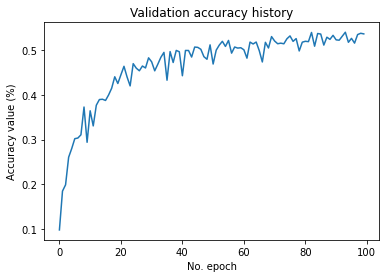

In [16]:
#Plot of Validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

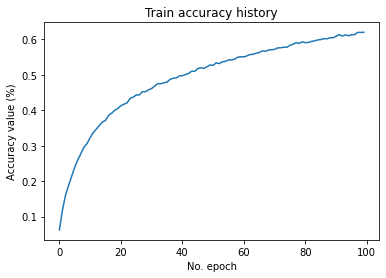

In [17]:
# plot of train accuracy
plt.plot(history.history['accuracy'])
plt.title('Train accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

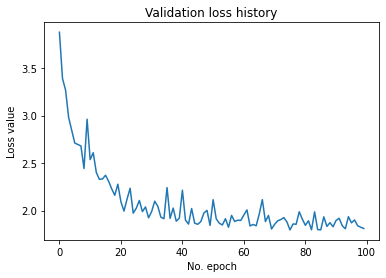

In [18]:
# plot of validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

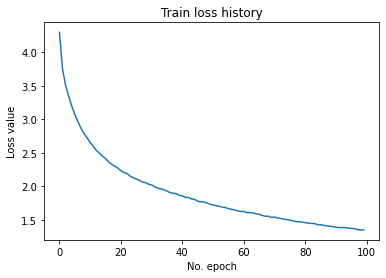

In [19]:
# plot of trian loss
plt.plot(history.history['loss'])
plt.title('Train loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

Text(0.5, 1.0, "b'lion'")

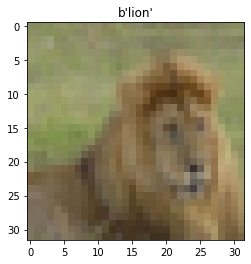

In [20]:
# printing example of predicted lable and actual image
test_index = 15

img = X_test[test_index]
plt.imshow(img)
plt.title(labels[np.argmax(model.predict(img.reshape(1,32,32,3)))])

In [21]:
Y_pred = model.predict(X_test)

In [22]:
# results
pred=np.argmax(Y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
print(classification_report(ground,pred))
print(accuracy_score(ground, pred))


              precision    recall  f1-score   support

           0       0.88      0.75      0.81       100
           1       0.62      0.69      0.65       100
           2       0.38      0.33      0.35       100
           3       0.42      0.32      0.36       100
           4       0.35      0.27      0.31       100
           5       0.55      0.51      0.53       100
           6       0.65      0.64      0.64       100
           7       0.57      0.62      0.59       100
           8       0.53      0.73      0.61       100
           9       0.78      0.62      0.69       100
          10       0.40      0.33      0.36       100
          11       0.42      0.43      0.42       100
          12       0.64      0.61      0.62       100
          13       0.58      0.42      0.49       100
          14       0.37      0.55      0.44       100
          15       0.43      0.51      0.47       100
          16       0.56      0.58      0.57       100
          17       0.74    

<AxesSubplot:>

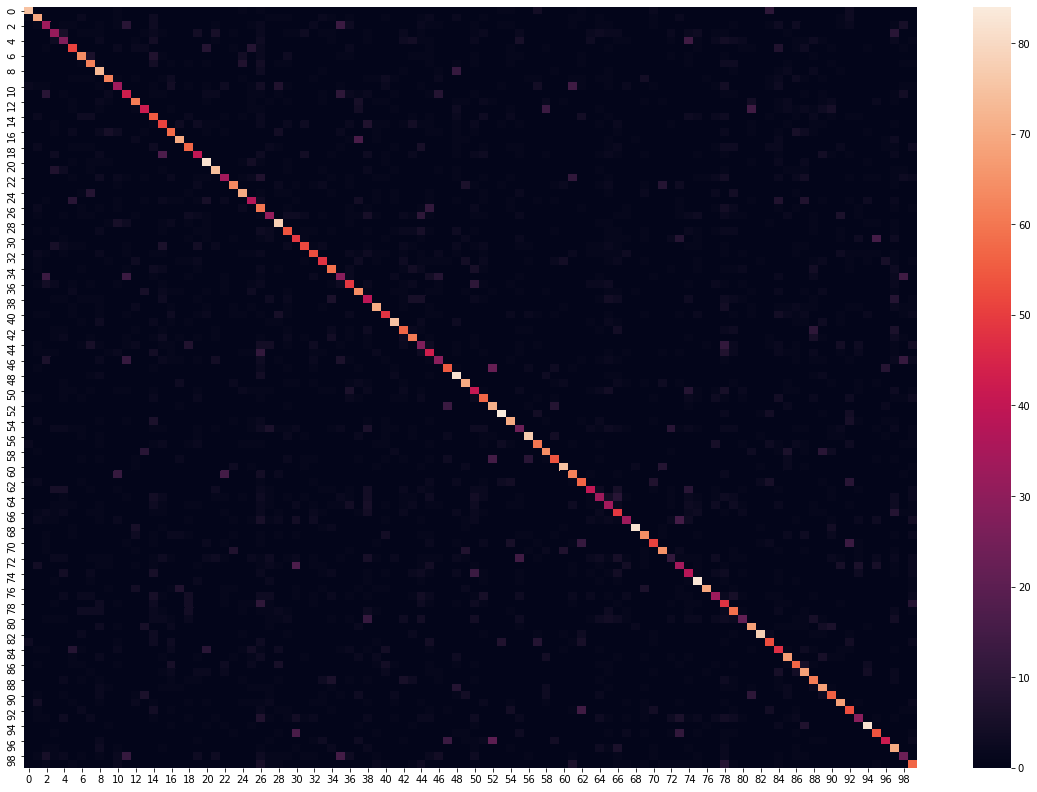

In [23]:
#confusion matrix
plt.figure(figsize = (20,14))
sn.heatmap(confusion_matrix(ground, pred))